# Environment

In [1]:
import platform
print(platform.python_version())

3.11.11


# Data

The authors use two real datasets in their [paper](https://arxiv.org/pdf/2312.05933): MIMIC-III and ADNI. In addition, they designed a synthetic dataset which replicates the input of their model, i.e. real data after pre-processing steps.

This synthetic dataset lets the authors and audiences focus on the core of the problem (i.e. model architecture), while capturing the essense of the nuances in healthcare data the authors attemp to address.

Specifically, each sample of the synthetic data replicates a patient's visit to a hospital. Each instance of a sample is a snapshot of the patient at a certain time. An entire sample (time series of instances) shows a progression of the patient; they could have gradually healed or deteriorated.

The synthetic data also captures the fact that there could be multiple reasons behind a deteriorating patient. For example, data for a patient with heart problem will look different from data for a patient with lung problem. One might observe a rapid decrease in blood pressure level while the other may see oxygen level problems. The synthetic data illustrates these different groups of patients (i.e. clusters) independently from the patients' outcomes.

The authors provided code to synthetic data generation in their [GitHub repository](https://github.com/Shahriarnz14/Temporal-Supervised-Contrastive-Learning/blob/main/model/utils/gerenate_data.py). This code can be found in `author/generate_data.py` in my project. Data can ge generated by simply calling `get_data_synthetic`.

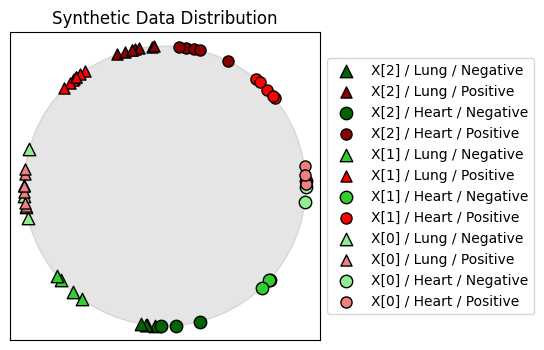

In [30]:
from author.generate_data import get_data_synthetic, plot_hypersphere

train_data = get_data_synthetic(num_data_points_per_cluster=250, sigma=0.1, seed=2025)
valid_data = get_data_synthetic(num_data_points_per_cluster=25, sigma=0.1, seed=2026)

plot_hypersphere(
    train_data['data_x'],
    train_data['data_y'],
    proportion_visualized=0.02,
    title_txt="Synthetic Data Distribution",
    data_pp=train_data['data_path'],
    marker_size=80,
    fig_size=(4, 4))

Let's continue to use the example of patients with heart problems and lung problems. While patients in real life will have more than three data points, this synthetic dataset simplifies each patient journey at a hospital into three: start (`X[0]`), non-terminal (`X[1]`), and terminal (`X[2]`). For example, a patient who was first admitted may have moderate blood pressure level at `X[0]` (again, in real life, there will be multitude of vitals, lab results, and other support data), slight increase at `X[1]`, and then BP value low enough at `X[2]` to trigger the model to classify this patient as "positive", or high risk.

This synthetic dataset generates samples of lung patients and heart patients, where each may have had classified as negative (low risk) and positive (high risk).

In [31]:
import torch
from torch.utils.data import DataLoader

from byoon6.dataset import SyntheticDataset

def load_data(data, flatten, shuffle):
    data_x = torch.tensor(data['data_x'], dtype=torch.float32)
    data_y = torch.tensor(data['data_y'], dtype=torch.long)

    if flatten:
        data_x = torch.flatten(data_x, end_dim=1)
        data_y = torch.flatten(data_y, end_dim=1)
    
    dataset = SyntheticDataset(data_x, data_y)
    loader = DataLoader(dataset, batch_size=32, shuffle=shuffle)
    
    return data_x, data_y, loader

# Pretraining

In [109]:
from torch.optim import Adam

from byoon6.model import TemporalSCLEncoder
from author.contrastive_losses import SupConLoss

def pretrain_encoder(encoder, train_data):
    num_epochs = 5
    criterion = SupConLoss(temperature=0.07)
    optimizer = Adam(encoder.parameters(), lr=1e-4)

    # Treat each time step sample independently
    _, _, train_loader = load_data(train_data, flatten=True, shuffle=True)

    for epoch in range(num_epochs):
        encoder.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x_hat = encoder(x)
            x_hat = torch.unsqueeze(x_hat, dim=1)
            loss = criterion(x_hat, y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        print(f"[Epoch {epoch+1}/{num_epochs}] SupCon Loss: {train_loss:.4f}")
    
    encoder.eval()

encoder = TemporalSCLEncoder(input_dim=2, hidden_dim=16, embedding_dim=3)
pretrain_encoder(encoder, train_data)

[Epoch 1/5] SupCon Loss: 5.8600
[Epoch 2/5] SupCon Loss: 5.2782
[Epoch 3/5] SupCon Loss: 4.9953
[Epoch 4/5] SupCon Loss: 4.6625
[Epoch 5/5] SupCon Loss: 4.4226


# Training

In [110]:
from sklearn.neighbors import NearestNeighbors

def create_pairs(train_data):
    # Treat each time step sample independently
    data_x, _, _ = load_data(train_data, flatten=True, shuffle=True)

    # Nearest neighbors 
    nn = NearestNeighbors(n_neighbors=len(data_x))
    nn.fit(data_x)

    # Prepare returning data
    pair_length = len(data_x) // 2
    left_pair = torch.zeros(len(data_x) // 2, data_x.shape[1], dtype=torch.float32)
    right_pair = torch.zeros(len(data_x) // 2, data_x.shape[1], dtype=torch.float32)

    # Iterate through all of data_x, and pair each item with another
    taken_indices = set()
    for current_index in range(len(data_x)):
        if current_index in taken_indices:
            continue
        pair_number = len(taken_indices) // 2    # Index of returning data
        taken_indices.add(current_index)         # Add to set to avoid "using" again
        # Find as many neighbors as possible, because some of them may have already been "used"
        for neighbor_index in nn.kneighbors([data_x[current_index]], return_distance=False)[0]:
            if neighbor_index not in taken_indices:
                taken_indices.add(neighbor_index)                # Add to set to avoid "using" again
                left_pair[pair_number] = data_x[current_index]   # Populate returning data
                right_pair[pair_number] = data_x[neighbor_index] # Populate returning data
                break

    return left_pair, right_pair

def collate_fn(data):
    left_pair, right_pair = zip(*data)
    batch_size = len(left_pair)                             # Size 16
    x = torch.zeros(batch_size * 2, 2, dtype=torch.float32) # Shape (32, 2)
    y = torch.zeros(batch_size * 2, dtype=torch.float32)    # Shape (32)
    for i, item in enumerate(left_pair):
        x[i] = item
        y[i] = i
    for i, item in enumerate(right_pair):
        x[batch_size + i] = item
        y[batch_size + i] = i
    
    # x: [...all left pairs, ...all right pairs]
    # y: [0, 1, 2, ..., 15, 0, 1, 2, ... , 15]
    return x, y

def train_jointly(encoder, temporal_net, pair_data):
    num_epochs = 5
    criterion_encoder = SupConLoss(temperature=0.07)
    optimizer = Adam(encoder.parameters(), lr=1e-4)

    # Sort of abusing SyntheticDataset class here
    # pair_data[0] = left_pair
    # pair_data[1] = right_pair
    train_data = SyntheticDataset(pair_data[0], pair_data[1])
    # Use batch size 16, because collate_fn will return double the size
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
    
    for epoch in range(num_epochs):
        encoder.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x_hat = encoder(x)
            x_hat = torch.unsqueeze(x_hat, dim=1)
            loss = criterion_encoder(x_hat, y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        print(f"[Epoch {epoch+1}/{num_epochs}] SupCon Loss: {train_loss:.4f}")

train_jointly(encoder, None, create_pairs(train_data))

[Epoch 1/5] SupCon Loss: 4.1307
[Epoch 2/5] SupCon Loss: 4.0862
[Epoch 3/5] SupCon Loss: 4.0301
[Epoch 4/5] SupCon Loss: 3.8784
[Epoch 5/5] SupCon Loss: 3.7723


In [45]:
# import torch
# from byoon6.model import TemporalSCLEncoder, TemporalSCLModel

# # Example dimensions
# batch_size = 8
# seq_len = 10
# input_dim = 20
# encoder_hidden_dim = 64
# embedding_dim = 32
# temporal_hidden_dim = 64
# predictor_hidden_dim = 64
# num_classes = 5

# # Create a random input tensor
# x = torch.randn(batch_size, seq_len, input_dim)

# # Initialize the model
# model = TemporalSCLModel(input_dim, encoder_hidden_dim, embedding_dim,
#                          temporal_hidden_dim, predictor_hidden_dim, num_classes)

# # Forward pass
# embeddings, pred_next, true_next, logits = model(x)

# print("Embeddings shape:", embeddings.shape)  # (batch_size, seq_len, embedding_dim)
# print("Predicted next embeddings shape:", pred_next.shape)  # (batch_size, seq_len - 1, embedding_dim)
# print("True next embeddings shape:", true_next.shape)  # (batch_size, seq_len - 1, embedding_dim)
# print("Logits shape:", logits.shape)  # (batch_size, num_classes)